In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import requests
import urllib
import json
import getpass
import matplotlib.pyplot as plt

# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.cargar_data import *
from functions.impresion import *

# Matrices de distancias

## Matriz de distancias entre centros medios de población de cada departamento

In [ ]:
# carga capa de centros medios de población
cp = gpd.read_file('capas/centro_poblacion.gpkg')

cp.head()

In [ ]:
def reproyectar_dd(df):
    "Reproyecta coordenadas de DF para usar en Google Distance Matrix API"
    # obtiene coordenadas en EPSG 4326
    lon = df.geometry.to_crs(epsg=4326).x
    lat = df.geometry.to_crs(epsg=4326).y
    df_repro = pd.concat( [ pd.DataFrame(list(lat), columns=['lat'] ), pd.DataFrame( list(lon), columns=['lon'] ) ], axis=1, sort=False)
    # concatena en un sólo string
    df_repro['latlon'] = df_repro.apply(lambda x:'%s,%s' % (x['lat'],x['lon']),axis=1)
    # concatena ambos df
    df_rep_concat = pd.concat([df, df_repro], axis=1, ignore_index=False)
    return df_rep_concat

In [ ]:
# aplica función
df_cp = reproyectar_dd(cp)
df_cp.head()

In [ ]:
def producto_cartesiano(df, variable):
    "Calcula el producto cartesiano del DF"
    df_coords = df[[variable, 'latlon']]
    df_coords.insert(2, "key", 0, True)
    df_pc = df_coords.merge(df_coords, on='key', how='outer').drop(columns='key')

    dict_rename = {variable + '_x': 'cod_ori',
                variable + '_y': 'cod_des',
                'latlon_x': 'latlon_ori',
                'latlon_y': 'latlon_des'}

    df_pc.rename(columns=dict_rename, inplace=True)

    # elimina misma cod origen-destino
    df_pc = df_pc[df_pc['cod_ori'] != df_pc['cod_des']]

    # concatena en un código de díada
    df_pc['cod'] = (df_pc['cod_ori'].astype(str).str.zfill(2) + 
                    df_pc['cod_des'].astype(str).str.zfill(2)).astype('int')
                    
    return df_pc

In [ ]:
df_pc = producto_cartesiano(df_cp, 'DEPTO')

In [ ]:
# matriz de distancia entre capitales departamentales de departamentos
def obtenerDist(ori, dest, API_KEY):
    '''
    Devuelve distancia en KM entre uno o varios pares de coordenadas
    geográficas, utilizando la API de Google Distance Matrix.
    '''
    APIurl = """https://maps.googleapis.com/maps/api/distancematrix/json?
                units=metric&mode=walking&origins={}
                &destinations={}&key={}""".format(ori, dest, API_KEY)
    
    # Obtener la respuesta y cargar la representacion en un string
    response = requests.get(APIurl)
    geodataString = response.text
    geodata = json.loads(geodataString)
    # si la API no devulve resultados, la distancia será 'None'
    if geodata['rows'][0]['elements'][0]['status']=='ZERO_RESULTS':
        distancia = None
    else:
        distancia = geodata['rows'][0]['elements'][0]['distance']['value']
    return distancia

In [ ]:
# setea la API KEY
API_KEY = getpass.getpass()

# ordena y resetea el índice
df_pc.sort_values(by=['cod_ori', 'cod_des'], inplace=True)
df_pc.reset_index(drop=True, inplace=True)

print(df_pc.shape[0])
df_pc.head(3)

In [ ]:
df_pc.shape[0]

In [ ]:
# prueba con 1 caso
obtenerDist( df_pc.latlon_ori[4] , df_pc.latlon_des[4] , API_KEY)

In [ ]:
# son 342 díadas de centros de población
# for loop para obtener una lista con las distancias entre cp
# aplica la función obtenerDistancia para combinaciones de cp
n_iter = df_pc.shape[0]
distancias = [obtenerDist(df_pc.latlon_ori[x] , df_pc.latlon_des[x] , API_KEY) for x in range(n_iter)]

In [ ]:
print(len(distancias))

In [ ]:
dist_series = pd.Series(distancias)
df_pc['distancia'] = dist_series.values
df_pc.head()

In [ ]:
# guarda
df_pc.to_csv('tablas/df_distancias_centro_poblacion.csv', index=False)

## Matriz de distancias entre localidades

In [ ]:
locs = cargar_datos_geo()[2][['CODLOC', 'geometry']]
locs.head()

In [ ]:
locs_rep = reproyectar_dd(locs)
locs_rep.head()

In [ ]:
locs_pc = producto_cartesiano(locs_rep, 'CODLOC').reset_index()
print(locs_pc.shape[0])
print(len(locs_pc.cod.unique()))
locs_pc.tail()

In [ ]:
# carga distancias entre localidades, precalculadas por pgRouting
distancias_pgr = pd.read_csv('tablas/df_distancias_localidades_pgrouting.csv', sep=';').drop_duplicates('cod')
print(distancias_pgr.shape[0])
print(len(distancias_pgr.cod.unique()))
distancias_pgr.head(2)

In [ ]:
locs_pc_dist = pd.merge(locs_pc, distancias_pgr, how='left', on='cod', indicator=True)
locs_pc_dist.head()

In [ ]:
locs_pc_dist.groupby('_merge').size()

In [ ]:
376382 + 1228

In [ ]:
locs_pc_dist.shape

In [ ]:
locs_pc_dist.head()

In [ ]:
variables = ['cod_ori', 'latlon_ori', 'cod_des', 'latlon_des', 'cod']
locs_pc_sin_dist = locs_pc.loc[locs_pc._merge=='left_only', variables]
locs_pc_sin_dist.head()

In [ ]:
# setea la API KEY
API_KEY = getpass.getpass()

In [ ]:
# ordena y resetea el índice
locs_pc_sin_dist.sort_values(by=['cod_ori', 'cod_des'], inplace=True)
locs_pc_sin_dist.reset_index(drop=True, inplace=True)

print(locs_pc_sin_dist.shape[0])
locs_pc_sin_dist.head(3)

In [ ]:
376995 + 1228

In [ ]:
lista_ori = list(locs_pc_sin_dist.latlon_ori)
lista_des = list(locs_pc_sin_dist.latlon_des)

In [ ]:
len(lista_des)

In [ ]:
n = locs_pc_sin_dist.shape[0]
# distancias = [obtenerDist(lista_ori[x], lista_des[x] , API_KEY) for x in range(n)]

In [ ]:
# guarda lo calculado para no volver a usar la API de Google
with open('tablas/dist_loc_faltantes_google.txt', 'w') as f:
    for item in distancias:
        f.write("%s\n" % item)

In [ ]:
locs_pc_sin_dist['distancia_m'] = distancias

In [ ]:
locs_dist = locs_pc_dist.loc[locs_pc_dist._merge == 'both'].append(locs_pc_sin_dist).drop(['index','_merge'], axis=1)

In [ ]:
locs_dist['distancia_m'] = locs_dist['distancia_m'].astype(int)

In [ ]:
locs_dist.head()

In [ ]:
# guarda
# locs_dist.to_csv('tablas/df_distancias_localidades.csv', index=False)

## Categoriza distancias

In [2]:
# recarga
locs_dist = pd.read_csv('tablas/df_distancias_localidades.csv')

In [3]:
def reclas_dist(df, old_var, new_var):
    """Reclasifica variable de distancias en cuatro categorías:
    1: Mayores a 200 km
    2: Entre 200 y 100 km
    3: Entre 100 y 50 km
    4: Menor a 50 km    
    """
    max_d = max(df[old_var])
    df.loc[df[old_var].between(200001, max_d),  new_var] = 1
    df.loc[df[old_var].between(100001, 200000), new_var] = 2
    df.loc[df[old_var].between(50001, 100000),  new_var] = 3
    df.loc[df[old_var].between(0, 50000),       new_var] = 4
    df[new_var] = df[new_var].astype(int)
    return df

In [4]:
locs_dist = reclas_dist(locs_dist, 'distancia_m', 'cat_dist')

locs_dist.head()

,cod_ori,latlon_ori,cod_des,latlon_des,cod,distancia_m,cat_dist
0,2220,"-30.425838214197817,-56.48691836714405",2521,"-30.25981089095717,-57.59820712208474",22202521,137927,2
1,2220,"-30.425838214197817,-56.48691836714405",2522,"-30.4311049027931,-57.438192602981864",22202522,111408,2
2,2220,"-30.425838214197817,-56.48691836714405",2621,"-30.720182604693377,-57.32943841744266",22202621,106867,2
3,2220,"-30.425838214197817,-56.48691836714405",2721,"-30.298276594314746,-56.970039630361384",22202721,58392,3
4,2220,"-30.425838214197817,-56.48691836714405",2724,"-30.212907501181586,-57.60354994479026",22202724,142223,2


In [5]:
conteo = locs_dist.groupby('cat_dist')['cod_ori'].count()
conteo

cat_dist
1    259454
2     68935
3     29891
4     19330
Name: cod_ori, dtype: int64

In [11]:
percent = conteo / conteo.sum() * 100

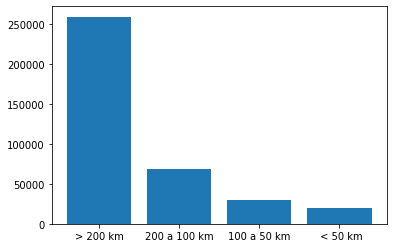

In [12]:
# grafica
x_pos = np.arange(4)

# Create bars
plt.bar(x_pos, conteo.values)
 
# Create names on the x-axis
labels =  ['> 200 km',
'200 a 100 km',
'100 a 50 km',
' < 50 km']

plt.xticks(x_pos, labels)
 
# Show graphic
plt.show()

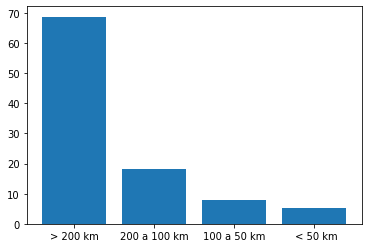

In [17]:
# grafica
x_pos = np.arange(4)

# Create bars
plt.bar(x_pos, percent)
plt.xticks(x_pos, labels)
 
# Show graphic
plt.show()